Loading necessary libraries and datasets

In [1]:
# our usual library for dataframa manipulation
import pandas as pd
# plotting library
import seaborn as sns
# library for missing data handling
import missingno as msno
# imports for missing data handling (imputation)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

Reading the Titanic dataset

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.head()

pclass  survived                                             name     sex  \
0     1.0       1.0                    Allen, Miss. Elisabeth Walton  female   
1     1.0       1.0                   Allison, Master. Hudson Trevor    male   
2     1.0       0.0                     Allison, Miss. Helen Loraine  female   
3     1.0       0.0             Allison, Mr. Hudson Joshua Creighton    male   
4     1.0       0.0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000    0.0    0.0   24160  211.3375       B5        S    2    NaN   
1   0.9167    1.0    2.0  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON


**Examining the Target column**

   The *Titanic dataset*  was created to help  build a model that predicts whether or not the passengers survived the sinking of the Titanic. The target column for such a model (i.e labels for a supervised model) is the `survived` column. We examine the distribution of this special column.



In [4]:
df['survived'].value_counts()

0.0    809
1.0    500
Name: survived, dtype: int64

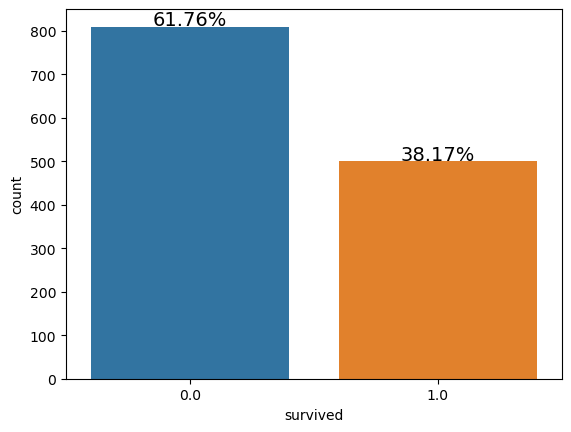

In [7]:
s = sns.countplot(x = 'survived',data = df)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df)*100),
            ha="center", fontsize=14)


## Detecting Missing values

**Detecting missing values numerically**

We first try and compute the count/percentage of missing values in every column of the dataset. This gives an idea about the distribution of missing values.



In [8]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction.
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
df_missing= missing_values_table(df)

Your selected dataframe has 14 columns.
There are 14 columns that have missing values.


In [10]:
df_missing

Missing Values  % of Total Values
body                 1189               90.8
cabin                1015               77.5
boat                  824               62.9
home.dest             565               43.1
age                   264               20.2
embarked                3                0.2
fare                    2                0.2
pclass                  1                0.1
survived                1                0.1
name                    1                0.1
sex                     1                0.1
sibsp                   1                0.1
parch                   1                0.1
ticket                  1                0.1

All columns in the dataset have missing values, with some to an extreme degree (e.g `body` with 90.8% of missing values).


**Detecting missing data visually using `Missingno` library**

  To graphically/visually analyse the missingness in the data, we use a library called `Missingno`: it is a package for the graphical analysis of missing values. To use this library, we need to import it as follows: `import missingno as msno` (see library import step above).



<Axes: >

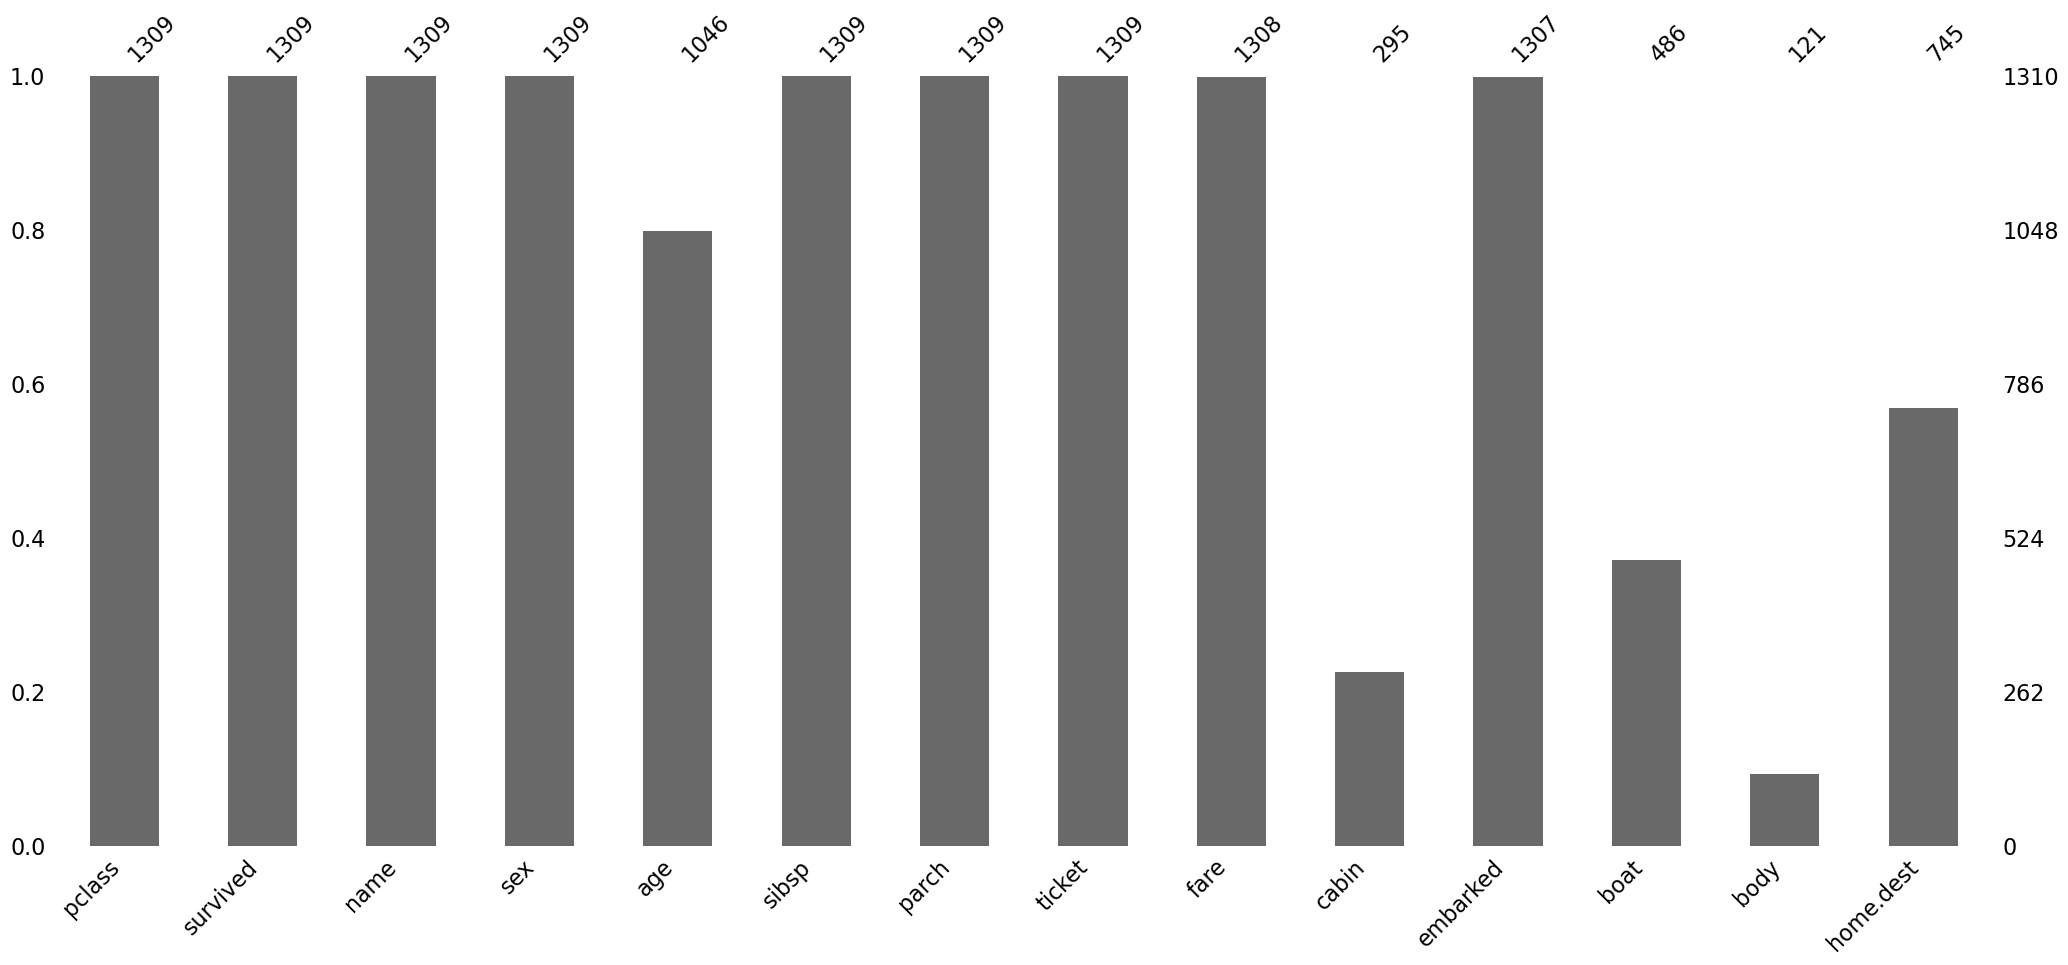

In [12]:
msno.bar(df)

The bar chart above gives a quick graphical overview of the completeness of the dataset. We can see that the `age`, `cabin` and `embarked` columns have missing values. Next, it would make sense to try and find out the locations of the missing data.


**Visualizing the locations of the missing data**

  The `msno.matrix` nullity matrix is a data-dense display which allows the user to quickly visually pick out patterns in data completeness.

  The plot appears blank/white where there are missing values. For example, in the `embarked` column, there are only three instances of missing data and therefore three white lines.

  The sparkline on the right gives an idea of the general shape of the completeness of the data and points out the row with the minimum nullities and the total number of columns in a given dataset, at the bottom.

<Axes: >

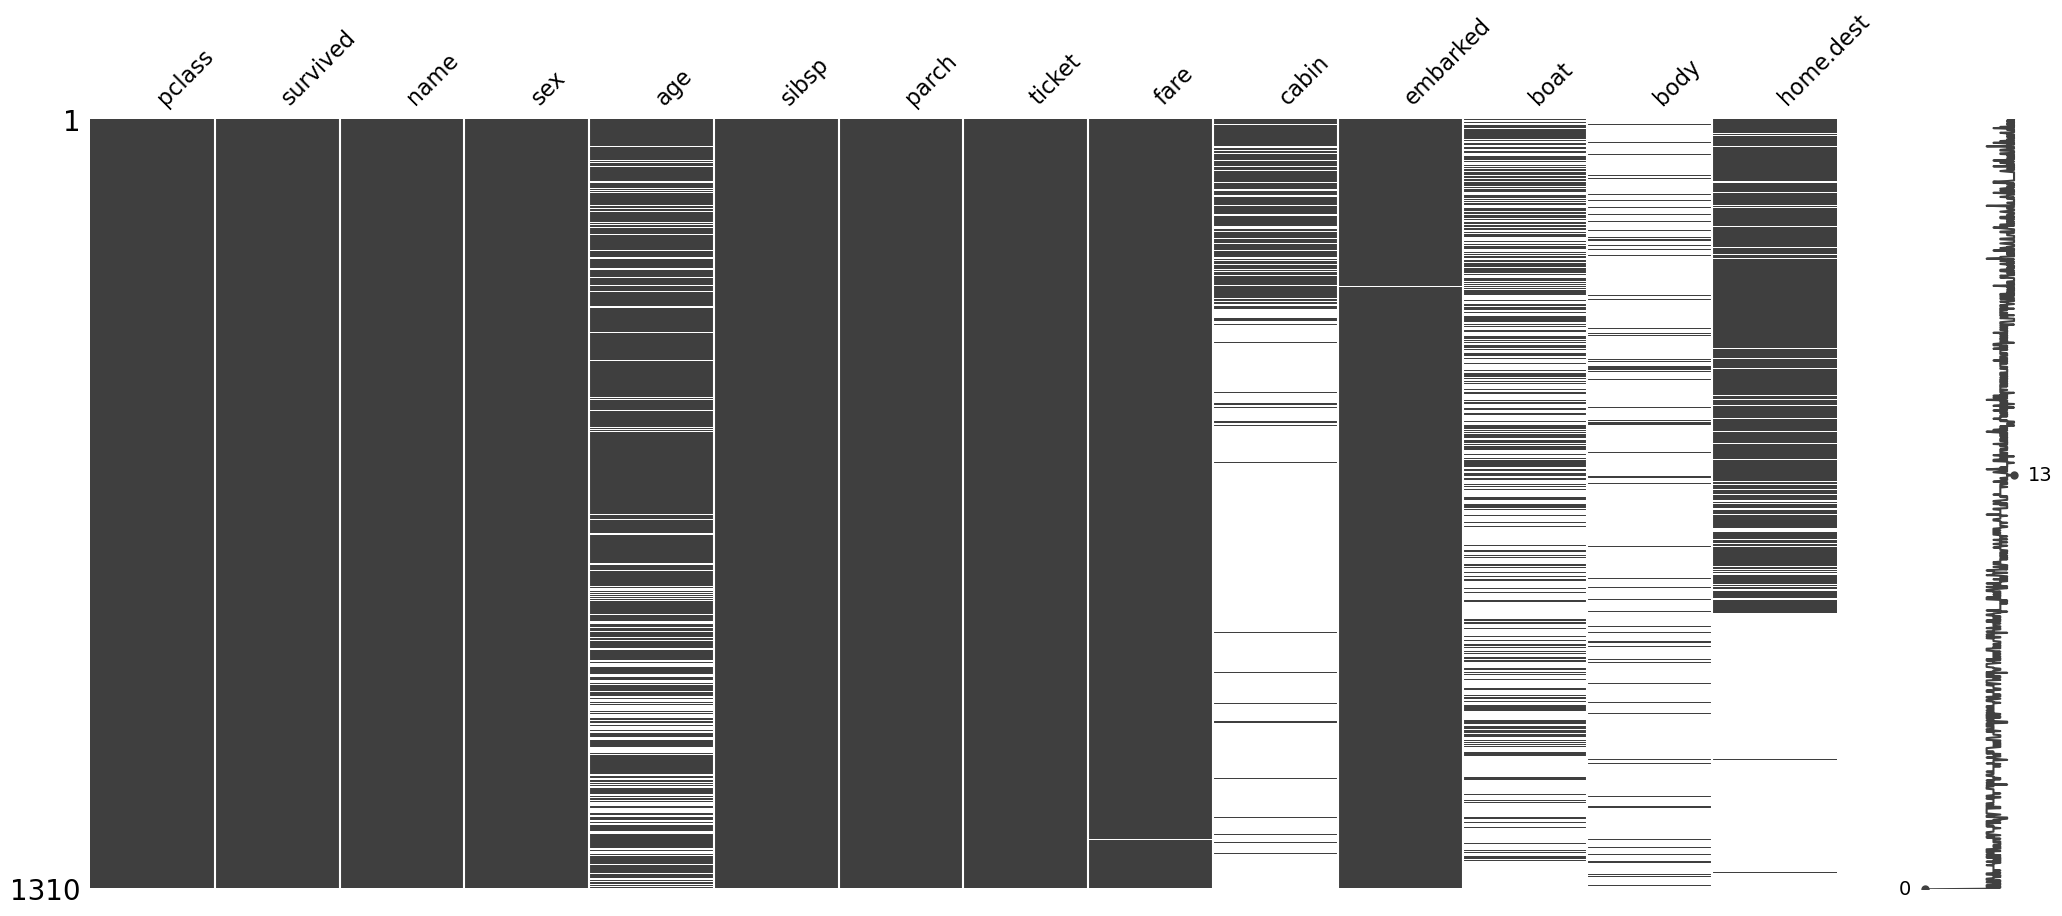

In [13]:
msno.matrix(df)

It is also possible to sample the dataset to pinpoint the exact location of the missing values. Let's check the first 100 rows for example.

<Axes: >

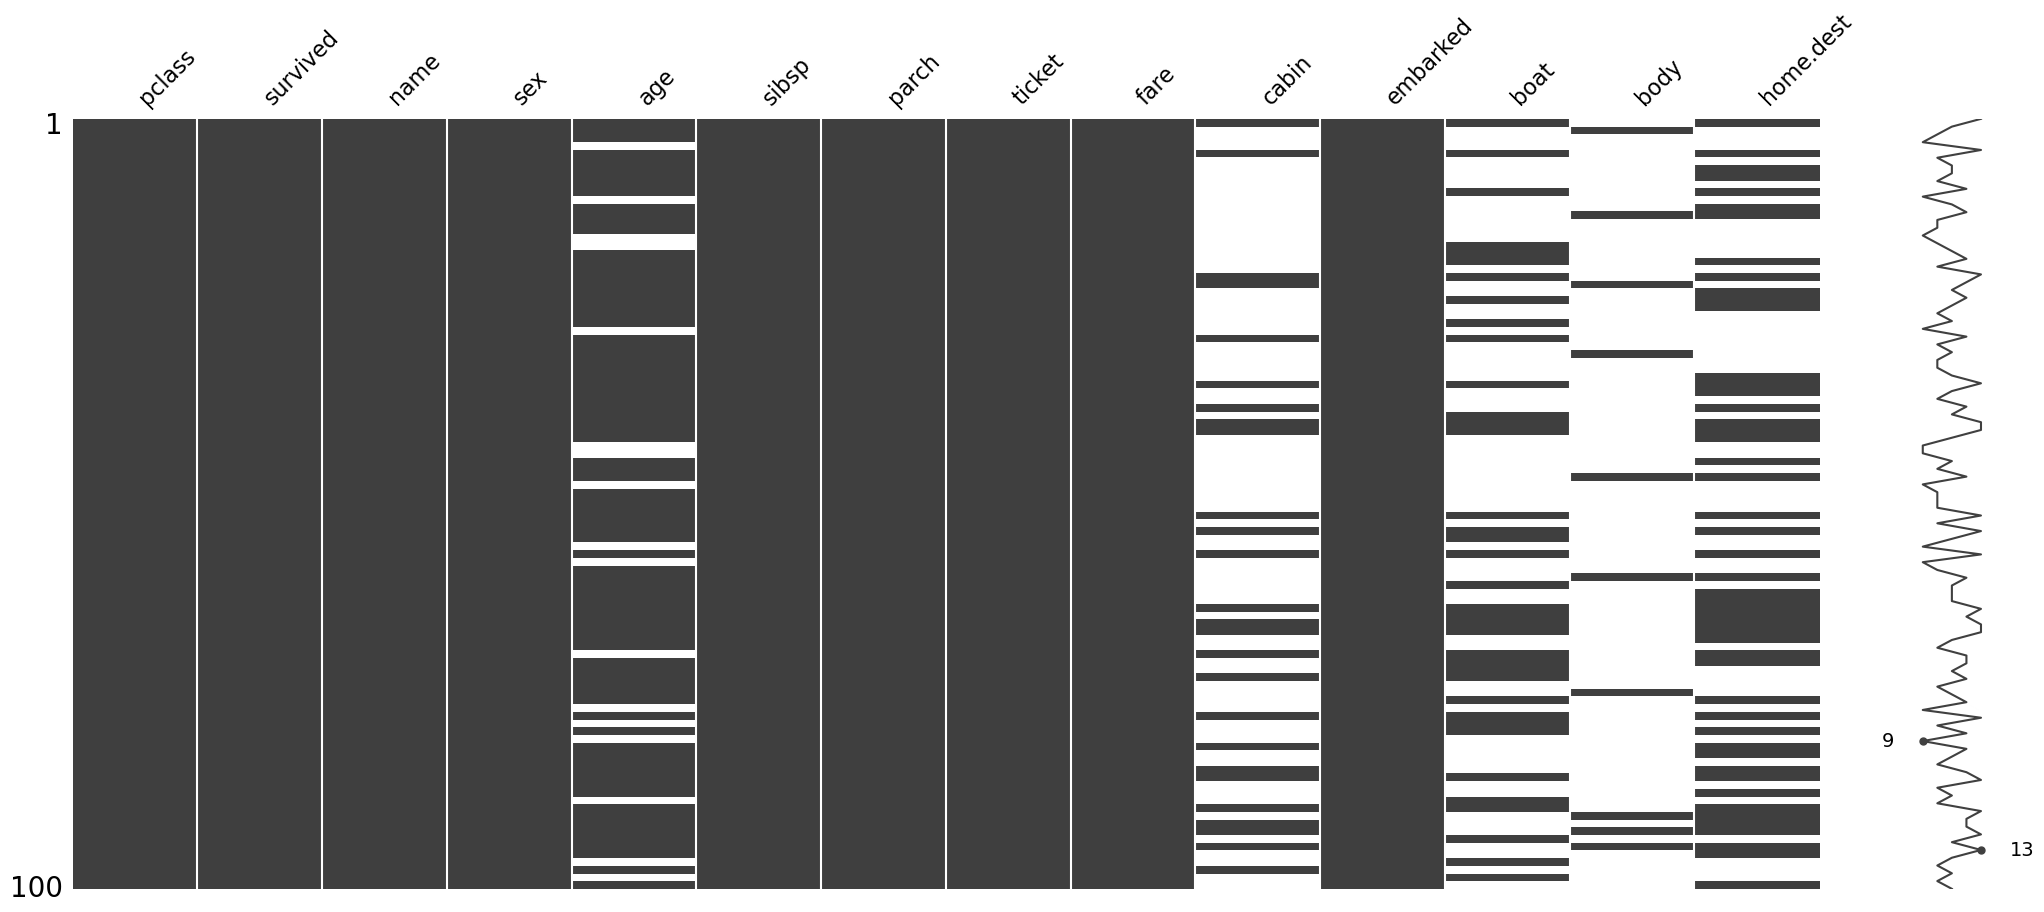

In [14]:
msno.matrix(df.sample(100))

This shows that the `embarked` column has no nullity in the first 100 cases.

**Reasons for Missing Values**

Before we start handling the missing values, it is important to understand the various reasons behind the missingness in the data. Broadly speaking, there can be three possible reasons (also called (data) missingness mechanisms):

  1. Missing Completely at Random (MCAR)

  The missing values on a given random variable (Y) are not associated/correlated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

  2. Missing at Random (MAR)

  The MAR mechanism occurs when the probability of missing values for a given random variable Y is related to some other measured variable (or variables) in the analysis model but not to the the values of Y itself.

  3. Missing Not at Random (MNAR)

  Missingness depends on variables unobserved in the data available or on the value of the random variable Y (which is missing values) itself.

  For more details, see Enders, Craig K. *Applied missing data analysis*. Guilford Publications, 2022. or Scheffer, Judi. *Dealing with missing data.* (2002).

  Now let us look at nullity matrix again to see if can find what type of missingness is present in the dataset.

<Axes: >

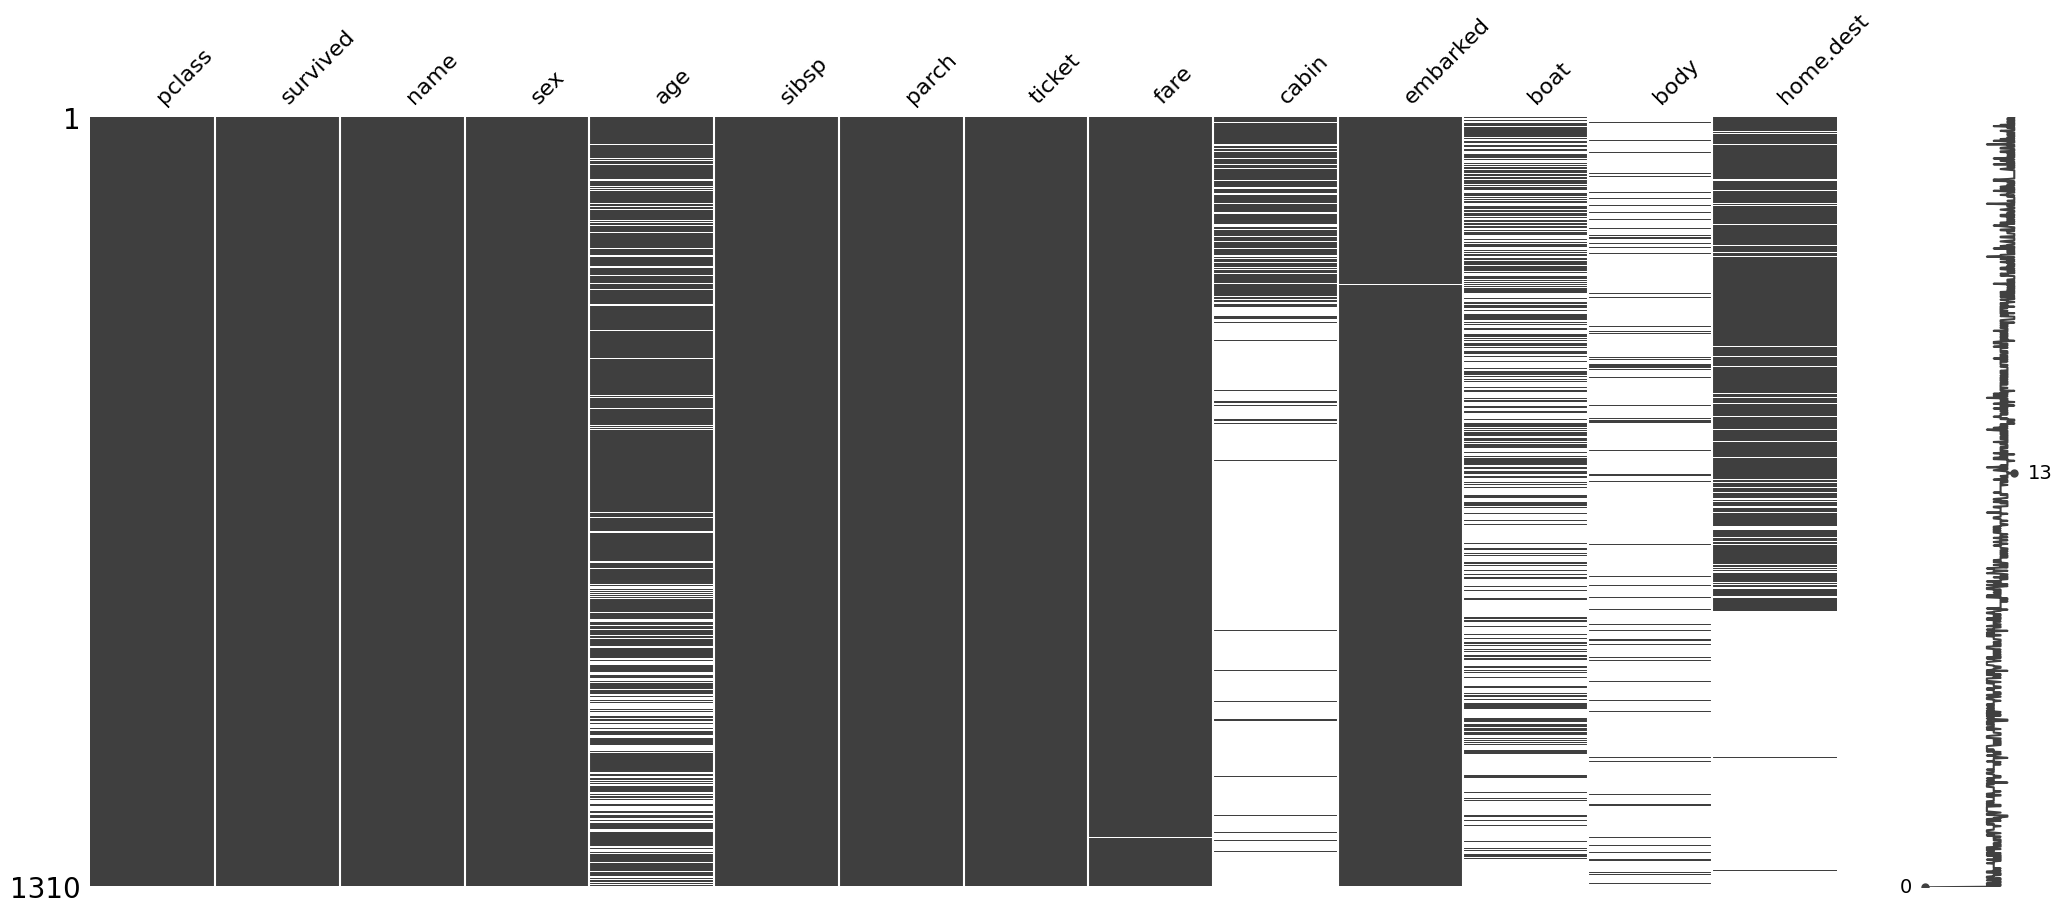

In [ ]:
msno.matrix(df)



  The `embarked` Column has very few missing values and does not seem to be correlated with any other column: therefore, the missingness in this column can be attributed as to the Missing Completely at Random (MCAR) mechanism.
        
  Both the `age` and the `cabin` columns have a lot of missing values: this could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.

  The `missingno` package also allows to us sort the graph by a particular column. So let's sort the values by `age` and `cabin` column to check whether there is a pattern in the missing values.


<Axes: >

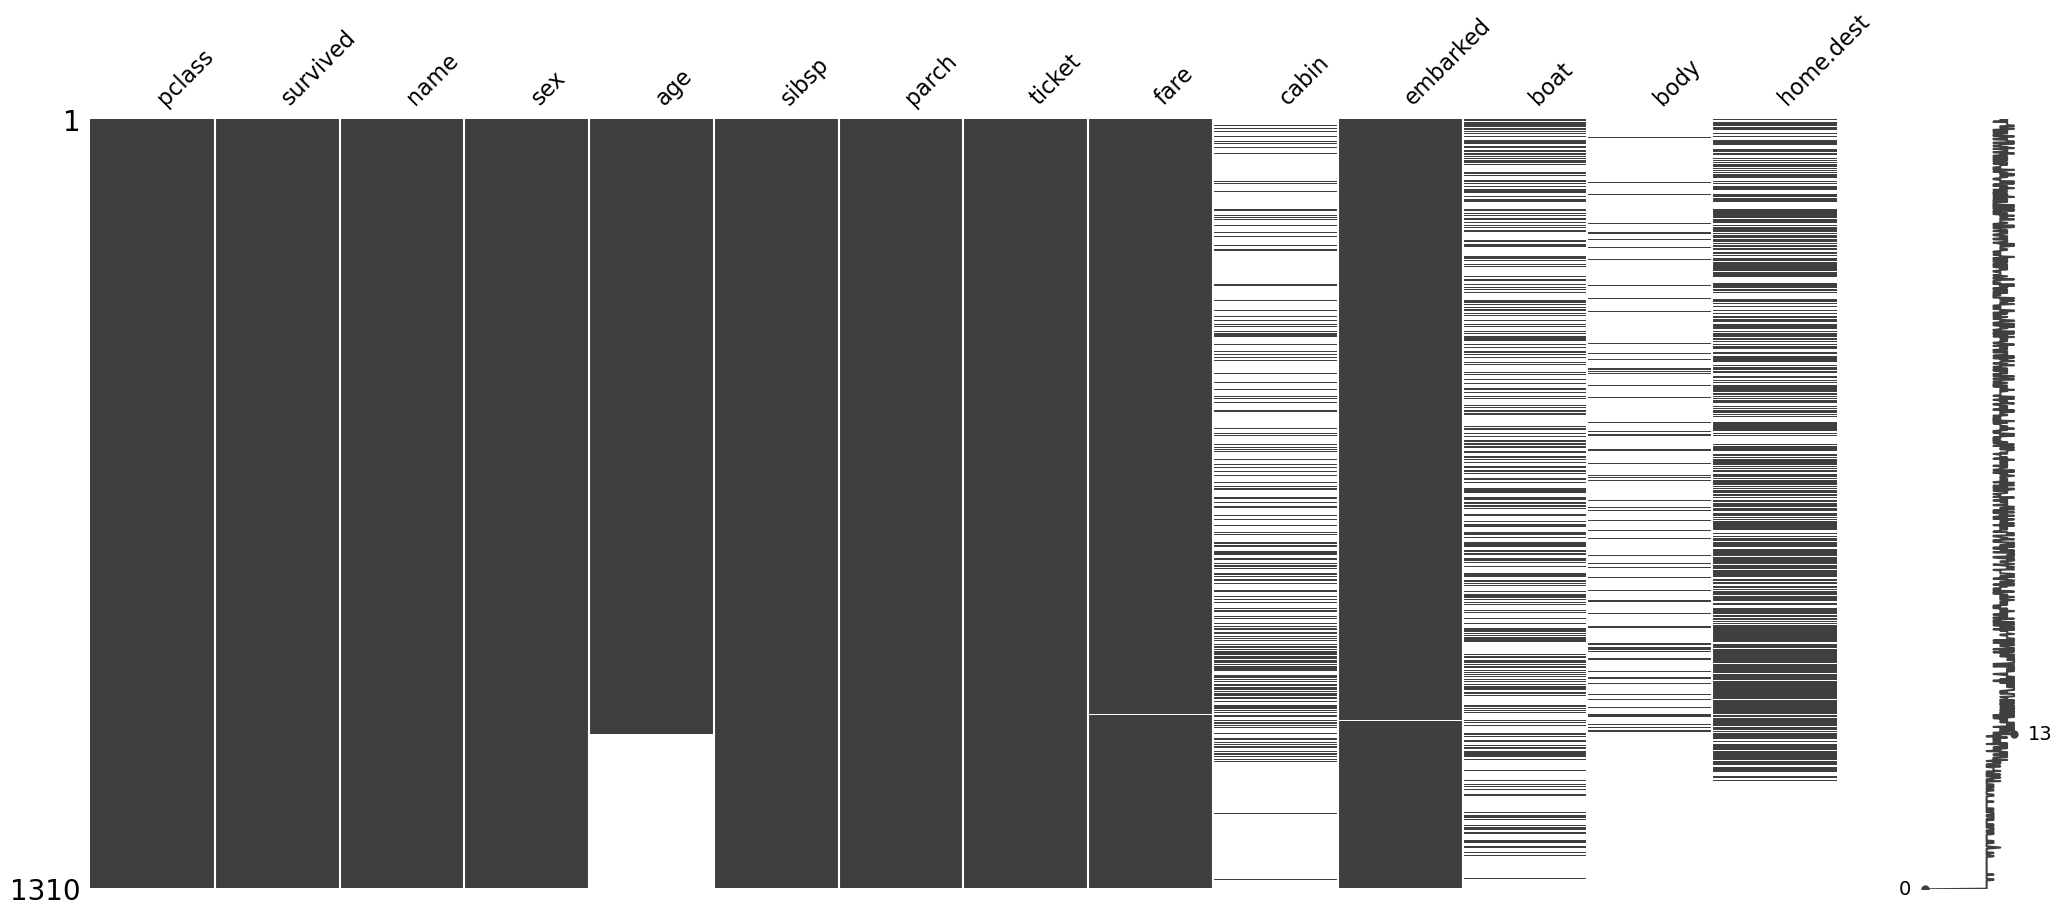

In [15]:
sorted = df.sort_values('age')
msno.matrix(sorted)

With this, it is clear that, here, there is no relation between the missingness in `age` and `cabin` columns. To reinforce this conclusion further, we can also draw a (correlation) Heatmap between the different variables in the dataset.


**Finding reason for missing data using a Heatmap**

The heatmap function shows that there are no strong correlations between missing values of different features: this is good; low correlations further suggest that the data are MAR.

<Axes: >

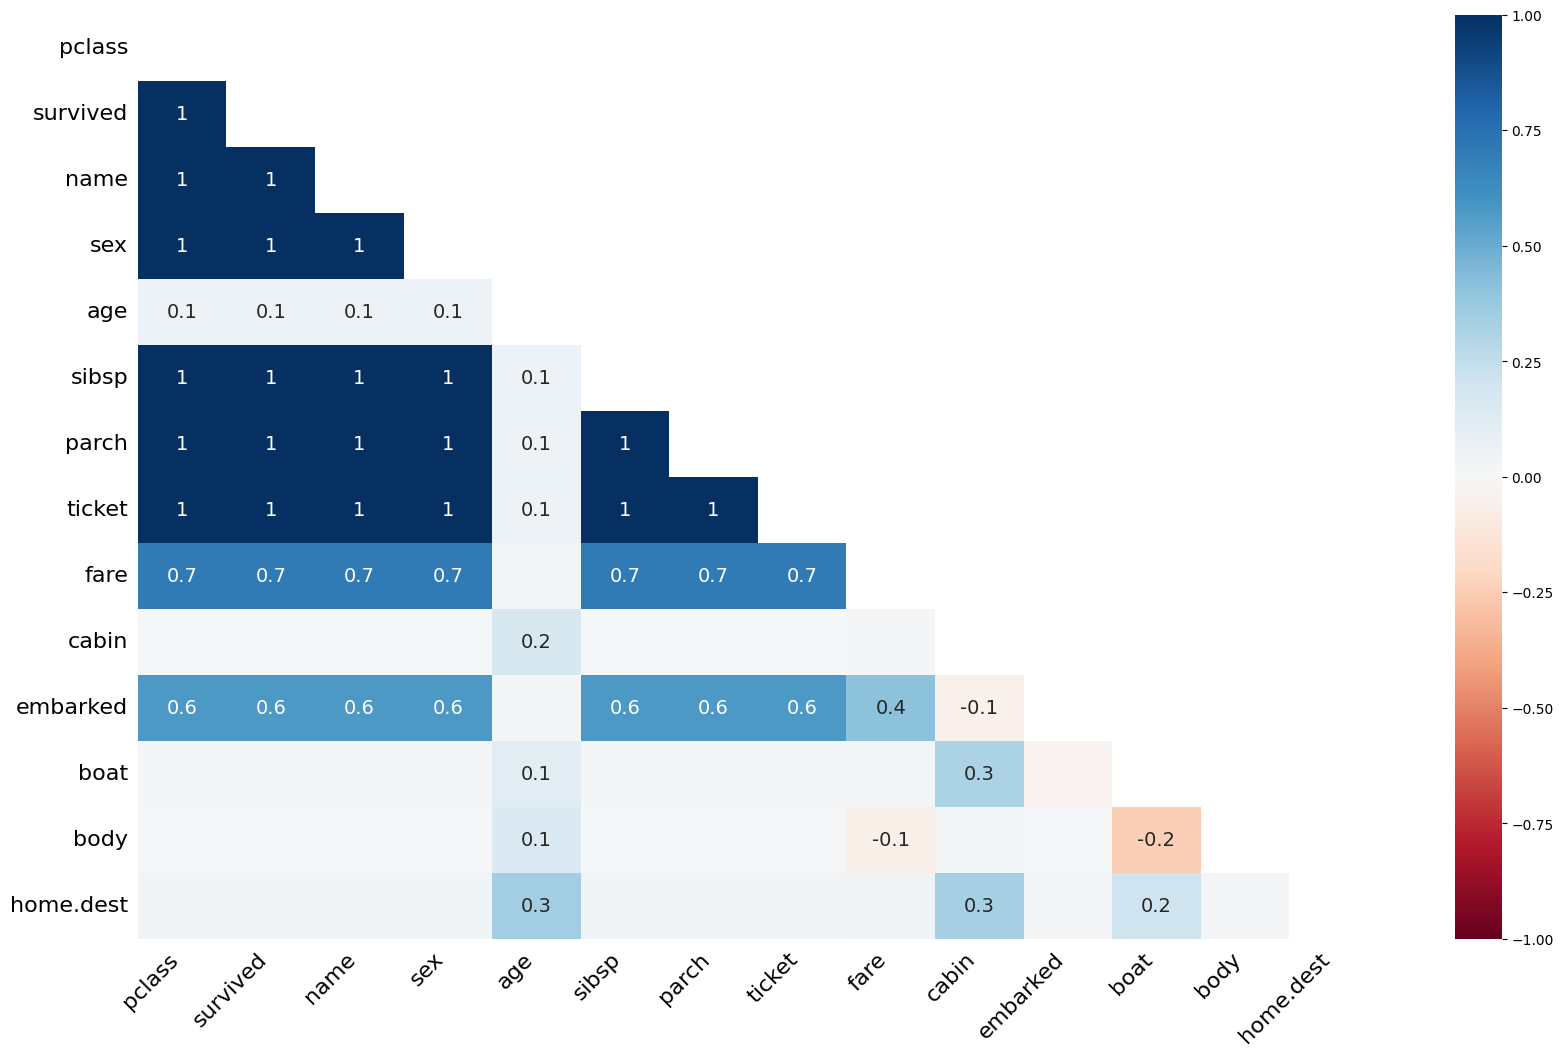

In [ ]:
msno.heatmap(df)


**Finding reason for missing data using Dendrogram**

A dendogram is a tree diagram of missingness. It groups highly correlated variables together.

Let's read the dendrogram below from a top-down perspective:

  - Cluster leaves which are linked together at a distance of zero fully predict one another's presence — one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on (`missingno` documentation)
  - the missingness of `embarked` tends to be more similar to `age` than to `cabin` and so on. However, in this particluar case, the correlation is high since `embarked` column has a very few missing values.

This dataset doesn't have that many missing values, but, if you use the same methodology on datasets that a lot more of missing values, some interesting pattern will definitely emerge.



<Axes: >

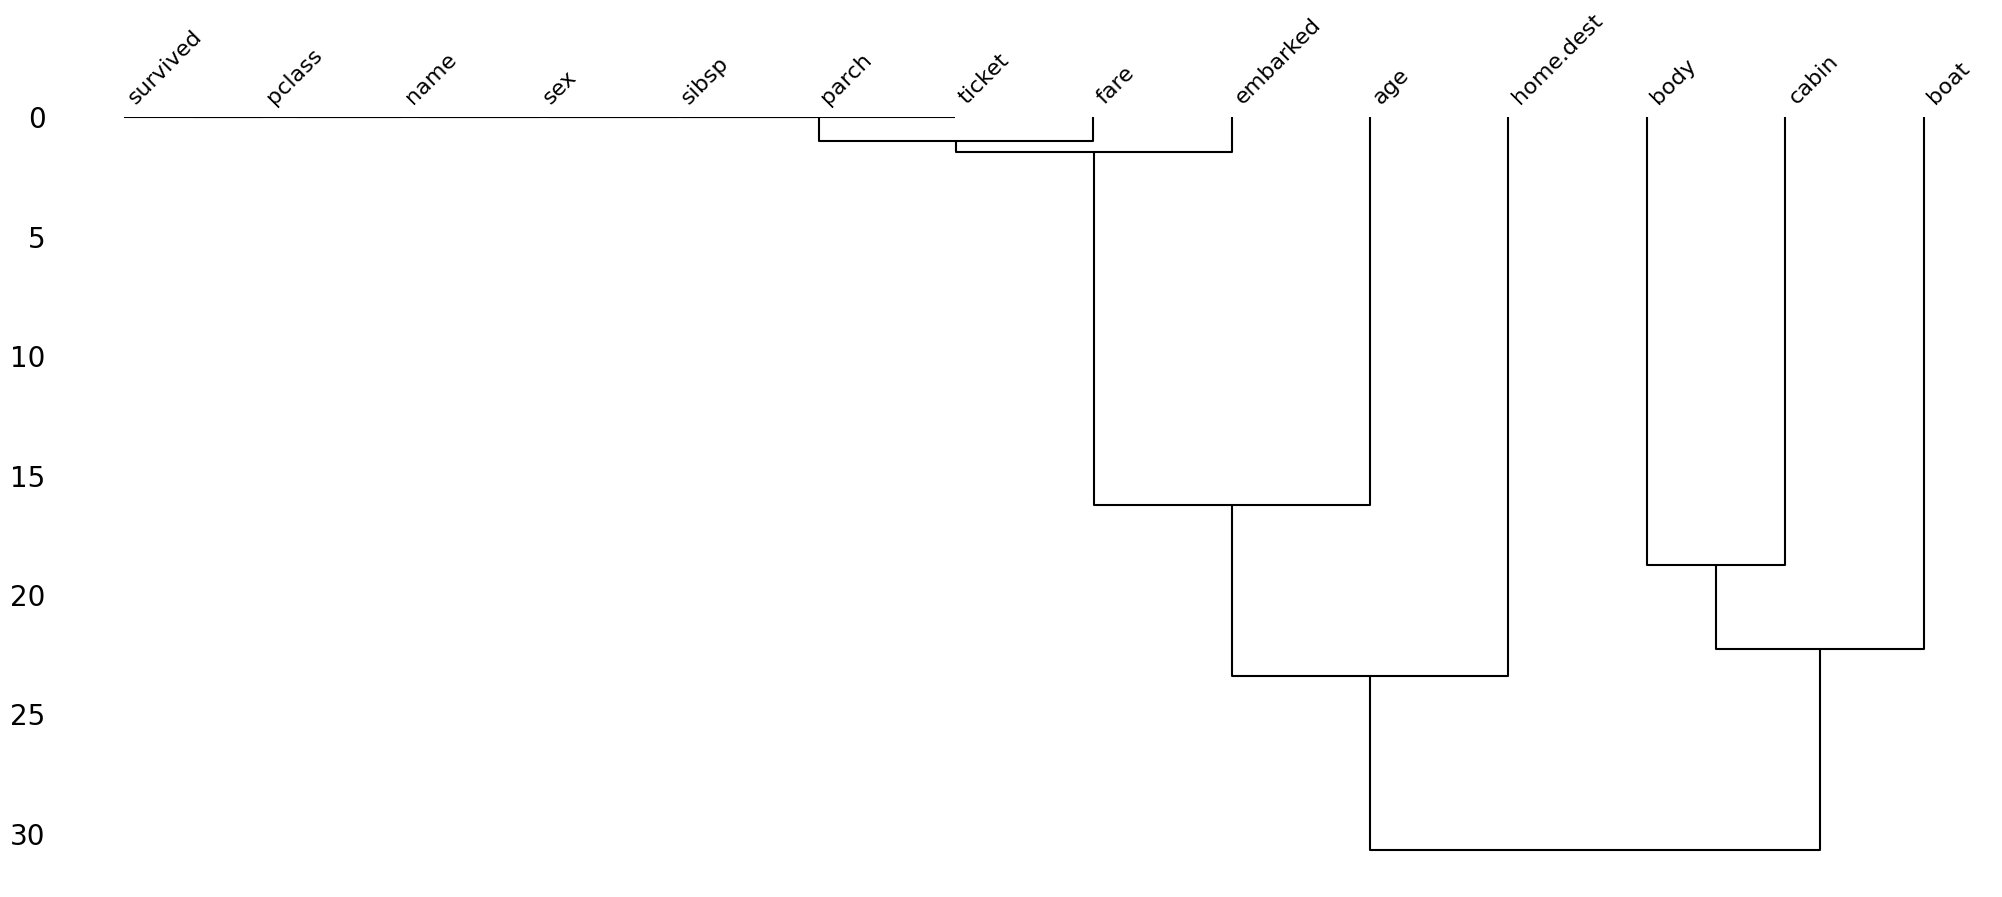

In [ ]:
msno.dendrogram(df)

**Handling missing data**

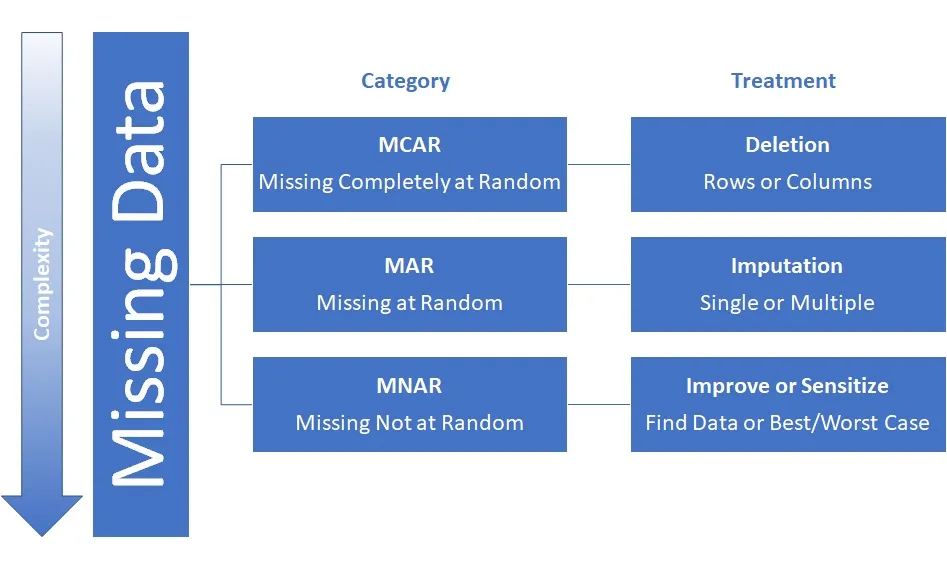

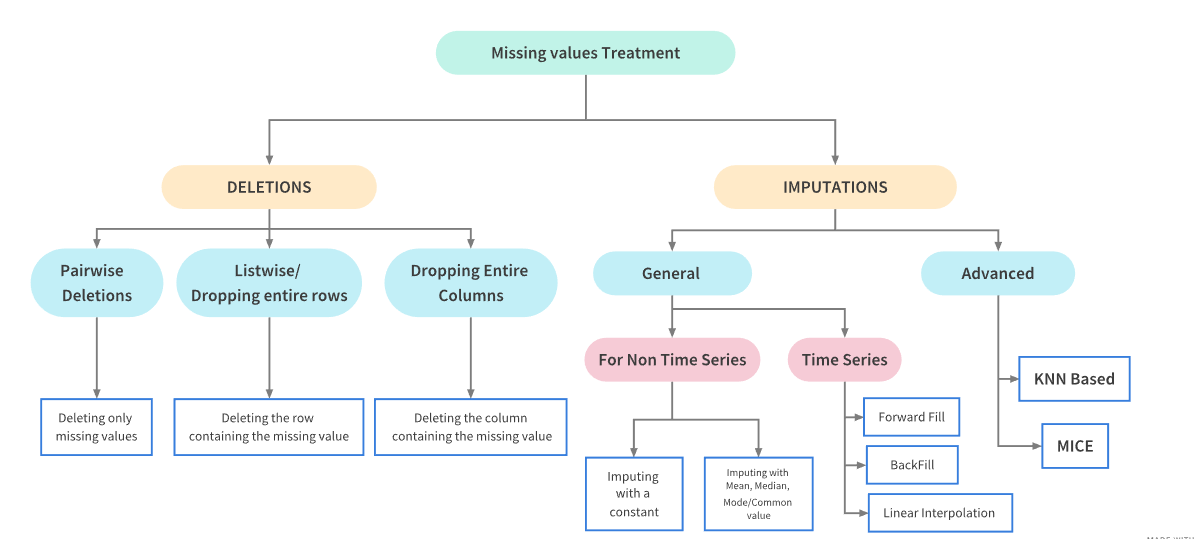

**Deletions**

Deletion means to delete the missing values from a dataset. This is however not recommended as it might result in loss of information from the dataset. We should only delete the missing values from a dataset if their proportion is very small and it is also only recommended in the case of random variables that are MCAR.

Deletions are further of three types:

*Pairwise Deletion*

Parwise Deletion is used when values are missing completely at random i.e MCAR. During Pairwise deletion, only the missing values are deleted. All operations in `pandas` such as `mean`, `sum` etc intrinsically skip missing values.

In [ ]:
df.isnull().sum()



pclass          1
survived        1
name            1
sex             1
age           264
sibsp           1
parch           1
ticket          1
fare            2
cabin        1015
embarked        3
boat          824
body         1189
home.dest     565
dtype: int64

In [ ]:
df_1 = df.copy()
df_1['age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

29.8811345124283


*Listwise Deletion/ Dropping rows*

During Listwise deletion, complete rows (which contain the missing values) are deleted: it is also called Complete Case deletion as a result. Like Pairwise deletion, listwise deletions are also only used for MCAR values.





In [ ]:
#Drop rows which contains any NaN or missing value for Age column
df_1.dropna(subset=['age'],how='any',inplace=True)
df_1['age'].isnull().sum()

0

  The `age` column doesn't have any missing values anymore following listwise deletion.
  A major disadvantage of Listwise deletion is that a major chunk of data and therefore a lot of information is lost. For this reason, it is advisable to use it only when the number of missing values is very small. And again, it is only really advisable to use deletion when the missingness mechanism is MCAR as you would otherwise also exercise undue influence on the relationships between the variables in your data through deletion!


*Dropping complete columns*

If a column contains a lot of missing values, say more than 80%, and the feature is not significant, you might want to delete that feature. Again, however, it is not a good methodology to delete data.


**Imputations Techniques for non Time Series Problems**

Imputation simply means replacing missing data with substitute values. There are many ways in which the missing values can be imputed depending upon the nature of the problem and data. Depending on the nature of the problem, imputation techniques can be broadly they can be classified as follows:

*Basic Imputation Techniques*

- Imputation with a constant value
- Imputation using statistics (mean, median or most frequent) of  each column in which the missing values are located

To demonstrate basic imputation, we will use the `The SimpleImputer` class from `sklearn`.

In [ ]:
from sklearn.impute import SimpleImputer
df_constant = df.copy()
#setting strategy to 'constant'
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
df_constant.iloc[:,:] = mean_imputer.fit_transform(df_constant)
df_constant.isnull().sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home.dest    0
dtype: int64

Showing first columns of new dataset after imputation

In [ ]:
df_constant.head(10)

pclass survived                                             name     sex  \
0    1.0      1.0                    Allen, Miss. Elisabeth Walton  female   
1    1.0      1.0                   Allison, Master. Hudson Trevor    male   
2    1.0      0.0                     Allison, Miss. Helen Loraine  female   
3    1.0      0.0             Allison, Mr. Hudson Joshua Creighton    male   
4    1.0      0.0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   
5    1.0      1.0                              Anderson, Mr. Harry    male   
6    1.0      1.0                Andrews, Miss. Kornelia Theodosia  female   
7    1.0      0.0                           Andrews, Mr. Thomas Jr    male   
8    1.0      1.0    Appleton, Mrs. Edward Dale (Charlotte Lamson)  female   
9    1.0      0.0                          Artagaveytia, Mr. Ramon    male   

      age sibsp parch    ticket      fare          cabin embarked  \
0    29.0   0.0   0.0     24160  211.3375             B5        S   
1  0.9167   1.0   2.0    113781    151.55        C22 C26        S   
2     2.0   1.0   2.0    113781    151.55        C22 C26        S   
3    30.0   1.0   2.0    113781    151.55        C22 C26        S   
4    25.0   1.0   2.0    113781    151.55        C22 C26        S   
5    48.0   0.0   0.0     19952     26.55            E12        S   
6    63.0   1.0   0.0     13502   77.9583             D7        S   
7    39.0   0.0   0.0    112050       0.0            A36        S   
8    53.0   2.0   0.0     11769   51.4792           C101        S   
9    71.0   0.0   0.0  PC 17609   49.5042  missing_value        C   

            boat           body                        home.dest  
0              2  missing_value                     St Louis, MO  
1             11  missing_value  Montreal, PQ / Chesterville, ON  
2  missing_value  missing_value  Montreal, PQ / Chesterville, ON  
3  missing_value          135.0  Montreal, PQ / Chesterville, ON  
4  missing_value  missing_value  Montreal, PQ / Chesterville, ON  
5              3  missing_value                     New York, NY  
6             10  missing_value                       Hudson, NY  
7  missing_value  missing_value                      Belfast, NI  
8              D  missing_value              Bayside, Queens, NY  
9  missing_value           22.0              Montevideo, Uruguay

In [ ]:
df[df["age"].isnull()] #rows where was NULL in original dataset

pclass  survived                                               name  \
15       1.0       0.0                                Baumann, Mr. John D   
37       1.0       1.0      Bradley, Mr. George ("George Arthur Brayton")   
40       1.0       0.0                          Brewe, Dr. Arthur Jackson   
46       1.0       0.0                              Cairns, Mr. Alexander   
59       1.0       1.0  Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...   
...      ...       ...                                                ...   
1297     3.0       0.0                             Wiseman, Mr. Phillippe   
1302     3.0       0.0                                  Yousif, Mr. Wazli   
1303     3.0       0.0                              Yousseff, Mr. Gerious   
1305     3.0       0.0                              Zabour, Miss. Thamine   
1309     NaN       NaN                                                NaN   

         sex  age  sibsp  parch      ticket     fare cabin embarked boat  \
15      male  NaN    0.0    0.0    PC 17318  25.9250   NaN        S  NaN   
37      male  NaN    0.0    0.0      111427  26.5500   NaN        S    9   
40      male  NaN    0.0    0.0      112379  39.6000   NaN        C  NaN   
46      male  NaN    0.0    0.0      113798  31.0000   NaN        S  NaN   
59    female  NaN    0.0    0.0       17770  27.7208   NaN        C    5   
...      ...  ...    ...    ...         ...      ...   ...      ...  ...   
1297    male  NaN    0.0    0.0  A/4. 34244   7.2500   NaN        S  NaN   
1302    male  NaN    0.0    0.0        2647   7.2250   NaN        C  NaN   
1303    male  NaN    0.0    0.0        2627  14.4583   NaN        C  NaN   
1305  female  NaN    1.0    0.0        2665  14.4542   NaN        C  NaN   
1309     NaN  NaN    NaN    NaN         NaN      NaN   NaN      NaN  NaN   

      body         home.dest  
15     NaN      New York, NY  
37     NaN   Los Angeles, CA  
40     NaN  Philadelphia, PA  
46     NaN               NaN  
59     NaN      New York, NY  
...    ...               ...  
1297   NaN               NaN  
1302   NaN               NaN  
1303   NaN               NaN  
1305   NaN               NaN  
1309   NaN               NaN  

[264 rows x 14 columns]

Showing an example of row where `age` value was imputed

Dataframe row 15 prior to imputation: the value of `age` is `NaN` here

In [18]:
df.iloc[15]

pclass                       1.0
survived                     0.0
name         Baumann, Mr. John D
sex                         male
age                          NaN
sibsp                        0.0
parch                        0.0
ticket                  PC 17318
fare                      25.925
cabin                        NaN
embarked                       S
boat                         NaN
body                         NaN
home.dest           New York, NY
Name: 15, dtype: object

After imputation with a constant value, the value of `age` has been replaced by `missing_value` instead

In [ ]:
df_constant.iloc[15]

pclass                       1.0
survived                     0.0
name         Baumann, Mr. John D
sex                         male
age                missing_value
sibsp                        0.0
parch                        0.0
ticket                  PC 17318
fare                      25.925
cabin              missing_value
embarked                       S
boat               missing_value
body               missing_value
home.dest           New York, NY
Name: 15, dtype: object

Simple imputation with most frequent value in column `age` (instead of constant)

In [19]:

df_most_frequent = df.copy() #creating a copy of the original dataframe `df`
#setting strategy to 'most_frequent' to impute by the most_frequent
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median
df_most_frequent.iloc[:,:] = mean_imputer.fit_transform(df_most_frequent)

Showing same example of row after imputation

In [ ]:
df_most_frequent.iloc[15]

pclass                       1.0
survived                     0.0
name         Baumann, Mr. John D
sex                         male
age                         24.0
sibsp                        0.0
parch                        0.0
ticket                  PC 17318
fare                      25.925
cabin                C23 C25 C27
embarked                       S
boat                          13
body                         1.0
home.dest           New York, NY
Name: 15, dtype: object

Showing that imputation does not leave NULL values in `age` column

In [ ]:
df_most_frequent['age'].isnull().sum()

0


**Advanced Imputation Techniques**

Advanced imputation techniques uses machine learning algorithms to impute the missing values in a dataset unlike the previous techniques where we used other column values to predict the missing values. Here are two examples of such techniques:

- [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)
- [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

*K-Nearest Neighbor Imputation*

The `KNNImputer` class of the `sklearn` library is an implementation of imputing missing values by using the k-Nearest Neighbors approach: each missing feature value is imputed using values from `n_neighbors` nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.


In [17]:
#creating a copy of the original dataframe
df_knn = df.copy(deep=True)

# initializing a KNN imputation (2 neighbours)
# For a full explanation of the parameters used in the imputation, check the documentation available at this link: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
#KNN imputation performed for `age` column in the dataframe
df_knn['age'] = knn_imputer.fit_transform(df_knn[['age']])

Showing an example of row after KNN imputation

In [ ]:
df_knn.iloc[15]

pclass                       1.0
survived                     0.0
name         Baumann, Mr. John D
sex                         male
age                    29.881135
sibsp                        0.0
parch                        0.0
ticket                  PC 17318
fare                      25.925
cabin                        NaN
embarked                       S
boat                         NaN
body                         NaN
home.dest           New York, NY
Name: 15, dtype: object

In [ ]:
df_knn['age'].isnull().sum()

0


*Multivariate feature imputation - Multivariate imputation by chained equations (MICE)*

A strategy for imputing missing values consists in modeling each feature with missing values as a function of other features in a round-robin fashion. It performs multiple regressions over random sample of the data, then takes the average of the multiple regression values and uses that value to impute the missing value. In `sklearn`, it is implemented as follows:


In [21]:
#creating a copy of original dataframe
df_mice = df.copy(deep=True)

#initializing multiple imputatiom
mice_imputer = IterativeImputer()
#performing multiple imputation on the `age` column
df_mice['age'] = mice_imputer.fit_transform(df_mice[['age']])

Showing an example of row after multiple imputation

In [22]:
df_mice.iloc[15]

pclass                       1.0
survived                     0.0
name         Baumann, Mr. John D
sex                         male
age                    29.881135
sibsp                        0.0
parch                        0.0
ticket                  PC 17318
fare                      25.925
cabin                        NaN
embarked                       S
boat                         NaN
body                         NaN
home.dest           New York, NY
Name: 15, dtype: object

In [23]:
df_mice['age'].isnull().sum()



0